# (Self Study) Vary optimizer for NN training

"Test drive" different optimizer options:

1. SGD (with different learning rates)
1. Adagrad
1. Adadelta
1. Adam

In [1]:
import io

import common
import nn_lib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import tensorflow as tf
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import torch.utils.tensorboard

In [2]:
LOG_DIR = "runs_02"

## Background

### Minibatch gradient descent

#### Motivation
- Gradient descent: Update parameters along the direction of the biggest decrease in loss
- Stochastic gradient descent can be very noisy
- Average gradient for each minibatch to accelerate learning

#### Algorithm
>>
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta\\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \\[.5em]
\quad \mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad \text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
\quad\quad \text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)}; \boldsymbol{\theta}\right), \mathbf{x}^{(i)} \right) \\[.5em]
\quad\quad \text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta\hspace{0.08em} \mathbf{g} \\[.5em]
\quad \mathbf{\text{end while}}
$

#### Implementation
- PyTorch: [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)

#### Limitations
- Choosing a proper learning rate: 
  - Too small: slow convergence
  - Too large: no convergence (loss function fluctuates around the minimum or diverges)
- Often decrease learning rate as training is progressing (annealing), but how should decay be scheduled?
- Same learning rate used for all parameter updates
- Converge to local minima, trapped in saddle points

### Stochastic gradient descent with momentum

#### Motivation
- "Ball rolling down a hill"
- Introduce velocity: direction and speed for parameter updates
- Use smoothing constant $\alpha$: the larger $\alpha$ (relative to learning rate) the more previous gradients affect the current update
- Dampens oscillations
- Momentum accelerates learning for small but consistent gradients or noisy gradients

#### Algorithm
>>
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta \text{ and momentum parameter } \alpha \\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \text{ and initial velocity } \mathbf{v} \\[.5em]
\quad \mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad\text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
\quad\quad\text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)}; \boldsymbol{\theta}\right), \mathbf{x}^{(i)} \right) \\[.5em]
{\quad\quad\color{blue}{ \text{Compute velocity update}\enspace\mathbf{v} \leftarrow \alpha\hspace{0.08em} \mathbf{v} - \eta\hspace{0.08em} \mathbf{g}}} \\[.5em]
\quad\quad\text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \mathbf{v} \\[.5em]
\quad\mathbf{\text{end while}}
$

#### Implementation
- PyTorch: [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
- Typically set momentum to 0.9

### Stochastic gradient descent with Nesterov momentum

#### Motivation
- SGD with momentum first computes gradient and then moves into the direction of the updated accumulated gradient
- SGD with Nesterov momentum evaluates the gradient at the updated parameter values and then performs the usual gradient-based update
- Correcting the next step for the anticipated gradients at the next parameter values can significantly increase the optimizer's performance

#### Algorithm
>>
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta \text{ and momentum parameter } \alpha \\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \text{ and initial velocity } \mathbf{v} \\[.5em]
\quad\mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad\text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
{\quad\quad\color{blue}{\text{Apply interim update}\enspace\boldsymbol{\tilde \theta} \leftarrow \boldsymbol{\theta} - \alpha\hspace{0.08em} \mathbf{v}}} \\[.5em]
\quad\quad\text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\tilde\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)}; \boldsymbol{\tilde\theta}\right), \mathbf{x}^{(i)} \right) \\[.5em]
\quad\quad\text{Compute velocity update}\enspace\mathbf{v} \leftarrow \alpha\hspace{0.08em} \mathbf{v} - \eta\hspace{0.08em} \mathbf{g} \\[.5em]
\quad\quad\text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \mathbf{v} \\[.5em]
\quad\mathbf{\text{end while}}
$

#### Implementation
- Paper: [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)
- PyTorch: [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
- Typically set momentum to 0.9

### AdaGrad

#### Motivation
- Learning rate is one of the most important hyperparameters, but only difficult to set
- Loss is sensitive to some directions in parameter space, but insensitive to others
- Also note link to features' observation frequencies
- AdaGrad adapts learning rates of all parameters by scaling them (inversely) proportional to the sum of the past squared gradient
- Well-suited for sparse data

#### Algorithm
>>
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta \\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \\[.5em]
\mathbf{\text{Require:}}\; \text{Constant } \varepsilon \text{ (for numerical stability), e.g., } \varepsilon=10^{-10} \\[.5em]
\quad \text{Initialize gradient accumulation with } \mathbf{r}=\mathbf{0} \\[.5em]
\quad \mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad \text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
\quad\quad \text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)}; \boldsymbol{\theta}\right), \mathbf{x}^{(i)} \right) \\[.5em]
{\quad\quad\color{blue}{\text{Accumulate squared gradient}\enspace\mathbf{r} \leftarrow \mathbf{r} + \mathbf{g} \odot \mathbf{g}}} \\[.5em]
\quad\quad \text{Compute gradient update}\enspace\Delta \boldsymbol{\theta} = \big( \eta \big/ \sqrt{\varepsilon + \mathbf{r}} \big) \odot \mathbf{g} \\[.5em]
\quad\quad \text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \Delta \boldsymbol{\theta} \\[.5em]
\quad \mathbf{\text{end while}}
$

#### Implementation
- Paper: [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](https://jmlr.org/papers/v12/duchi11a.html)
- PyTorch: [`torch.optim.Adagrad`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adagrad)
- Most implementations use a fixed learning rate of 0.01

### RMSProp

#### Motivation
- Adagrad's main weakness is the accumulation of the squared gradients causing the learning rate to shrink

#### Algorithm
>>
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta \text{ and decay parameter } \alpha \\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \\[.5em]
\mathbf{\text{Require:}}\; \text{Constant } \varepsilon \text{ (for numerical stability), e.g., } \varepsilon=10^{-8} \\[.5em]
\quad\text{Initialize gradient accumulation with } \mathbf{r}=\mathbf{0} \\[.5em]
\quad\mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad\text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
\quad\quad\text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)}; \boldsymbol{\theta}\right), \mathbf{x}^{(i)} \right) \\[.5em]
{\color{blue}{\quad\quad\text{Accumulate squared gradient}\enspace\mathbf{r} \leftarrow \alpha\hspace{0.08em}\mathbf{r} + (1-\alpha)\hspace{0.08em}\mathbf{g} \odot \mathbf{g}}} \\[.5em]
\quad\quad\text{Compute gradient update}\enspace\Delta \boldsymbol{\theta} = \big( \eta \big/ \sqrt{\varepsilon + \mathbf{r}} \big) \odot \mathbf{g} \\[.5em]
\quad\quad\text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \Delta \boldsymbol{\theta} \\[.5em]
\quad \mathbf{\text{end while}}
$

#### Implementation
- PyTorch: [`torch.optim.RMSprop`](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop)
- Typically set $\alpha$ to 0.99 and $\eta$ to 0.01

### Adam

#### Motivation
- Can be viewed as a version of RMSProp with momentum

#### Algorithm
>> 
$
\mathbf{\text{Require:}}\; \text{Learning rate } \eta\\[.5em]
\mathbf{\text{Require:}}\; \text{Exponential decay rates for moment estimates } \beta_1, \beta_2 \in [0, 1) \\[.5em]
\mathbf{\text{Require:}}\; \text{Initial parameters } \boldsymbol{\theta} \\[.5em]
\mathbf{\text{Require:}}\; \text{Constant } \varepsilon \text{ (for numerical stability), e.g., } \varepsilon=10^{-8} \\[.5em]
\quad\text{Initialize first and second moment variables } \mathbf{r}=\mathbf{0}, \mathbf{s}=\mathbf{0} \\[.5em]
\quad\text{Initialize time step } t=0 \\[.5em]
\quad\mathbf{\text{while}}\; \text{stopping criterion not met } \mathbf{\text{do}} \\[.5em]
\quad\quad\text{Sample minibatch of } m \text{ examples from the training set } \mathbf{x}^{(m)} \text{ with corresponding targets } \mathbf{y}^{(m)} \\[.5em]
\quad\quad\text{Update time step}\enspace t \leftarrow t + 1 \\[.5em]
\quad\quad\text{Compute gradient}\enspace\mathbf{g} \leftarrow \frac 1 m \nabla_\boldsymbol{\theta} \sum_i L\left(f\left(\mathbf{x}^{(i)};\boldsymbol{\theta}\right), \mathbf{x}^{(i)} \right) \\[.55em]
{\color{blue}{\quad\quad\text{Update first moment estimate}\enspace \mathbf{s} \leftarrow \beta_1 \mathbf{s} + (1-\beta_1)\hspace{0.08em}\mathbf{g}}} \\[.75em]
\quad\quad\text{Update second moment estimate}\enspace \mathbf{r} \leftarrow \beta_2 \mathbf{r} + (1-\beta_2)\hspace{0.08em} \mathbf{g} \odot \mathbf{g} \\[.5em]
{\color{blue}{\quad\quad\text{Correct bias in first and second moment estimate}\enspace \mathbf{\tilde s} \leftarrow \mathbf{s} \big/ (1-\beta_1^{t}),\, \mathbf{\tilde r} \leftarrow \mathbf{r} \big/ (1-\beta_2^{t})}} \\[.5em]
\quad\quad\text{Compute gradient update}\enspace\Delta \boldsymbol{\theta} = \big( \eta \big/ \sqrt{\varepsilon + \mathbf{\tilde r}} \big) \odot \mathbf{\tilde s} \\[.5em]
\quad\quad \text{Apply update}\enspace\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \Delta \boldsymbol{\theta} \\[.5em]
\quad \mathbf{\text{end while}}
$

#### Implementation
- Paper: [Adam: a Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
- PyTorch: [`torch.optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)
- Typically set $\beta$ to (0.9, 0.999) and $\varepsilon$ to 0.001


## Data

In [3]:
X, y = nn_lib.generate_data(N=2_000)

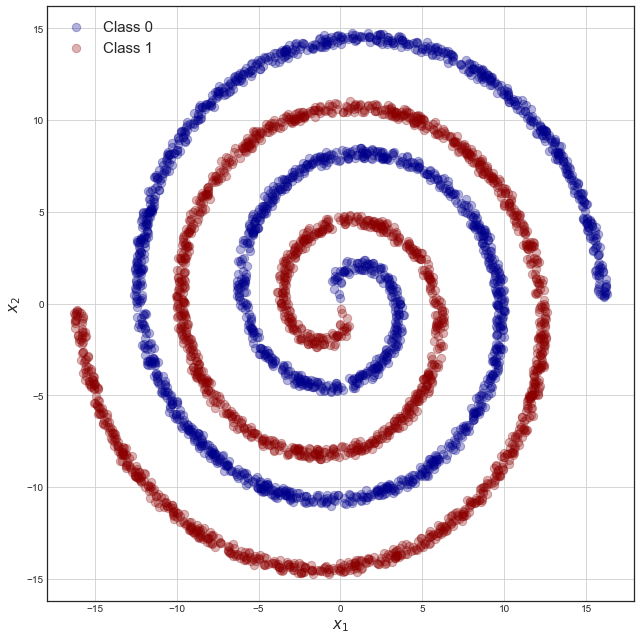

In [4]:
nn_lib.plot_spiral(X, y)

In [5]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=501
)

## Training based on different optimizers

### Seeds for reproducibility

In [6]:
torch.manual_seed(501)
np.random.seed(501)

### Config

In [7]:
config = {
    "trainer": {
        "epochs": 1_000,
    },
    "model": {
        "n_features": 2,
        "layers": [20, 15, 10, 5],
    },
    "data": {
        "train": {
            "batch_size": 512,
            "shuffle": True,
            "drop_last": True,
        },
        "valid": {
            "batch_size": x_valid.shape[0],
            "shuffle": False,
            "drop_last": False,
        },
    },
    "optimizer": {
        "lr": 0.01,
    },
}

### Data loader

In [8]:
xt_train, yt_train, xt_valid, yt_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
ds_train = torch.utils.data.TensorDataset(xt_train, yt_train)
dl_train = torch.utils.data.DataLoader(ds_train, **config["data"]["train"])

### Modified trainer class

In [9]:
class Trainer:
    def __init__(self, train, validation, optim, experiment, lr):

        self.train = train
        self.validation = validation
        self.writer = torch.utils.tensorboard.SummaryWriter(experiment)
        self.model = nn_lib.Net(**config["model"])
        if optim == "SGD":
            self.opt = torch.optim.SGD(self.model.parameters(), lr=lr)
        elif optim == "Adam":
            self.opt = torch.optim.Adam(self.model.parameters(), lr=0.001)
        elif optim == "Adagrad":
            self.opt = torch.optim.Adagrad(self.model.parameters(), lr=0.01)
        elif optim == "Adadelta":
            self.opt = torch.optim.Adadelta(self.model.parameters(), lr=1.0)
        else:
            raise Exception("Unknown optimizer")

    def fit(self, config):
        for epoch in range(config["trainer"]["epochs"]):

            self.model.train()
            for xb, yb in self.train:
                self.opt.zero_grad()
                loss_train = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(xb).flatten(), yb
                )
                loss_train.backward()
                self.opt.step()

            self.model.eval()
            with torch.no_grad():
                loss_valid = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(self.validation[0]).flatten(), self.validation[1]
                )

            self.writer.add_scalar("loss/train", loss_train, epoch)
            self.writer.add_scalar("loss/valid", loss_valid, epoch)

        self.writer.flush()
        self.writer.close()

### Training

#### SGD

In [10]:
trainer = Trainer(
    train=dl_train,
    validation=[xt_valid, yt_valid],
    optim="SGD",
    experiment=f"{LOG_DIR}/sgd-00",
    lr=0.01,
)
trainer.fit(config)

In [11]:
trainer = Trainer(
    train=dl_train,
    validation=[xt_valid, yt_valid],
    optim="SGD",
    experiment=f"{LOG_DIR}/sgd-01",
    lr=0.10,
)
trainer.fit(config)

#### Adagrad

In [12]:
trainer = Trainer(
    train=dl_train,
    validation=[xt_valid, yt_valid],
    optim="Adagrad",
    experiment=f"{LOG_DIR}/adagrad-00",
    lr=0.1,
)
trainer.fit(config)

#### Adadelta

In [13]:
for i in range(3):
    trainer = Trainer(
        train=dl_train,
        validation=[xt_valid, yt_valid],
        optim="Adadelta",
        experiment=f"{LOG_DIR}/adadelta-{i:02d}",
        lr=None,
    )
    trainer.fit(config)

#### Adam

In [14]:
for i in range(3):
    trainer = Trainer(
        train=dl_train,
        validation=[xt_valid, yt_valid],
        optim="Adam",
        experiment=f"{LOG_DIR}/adam-{i:02d}",
        lr=None,
    )
    trainer.fit(config)

## Further reading
- [Automatic Differentiation in Machine Learning: a Survey](https://arxiv.org/pdf/1502.05767.pdf)
- [A nice visualization](https://www.deeplearning.ai/ai-notes/optimization/)

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 3, Lecture 11 <br>
2021/22 <br>